## selenium을 이용하여 새올 전자민원 창구의 민원 데이터를 자동화 크롤링 하기

In [1]:
#셀레니움 설치
!pip install selenium

In [2]:
# 웹드라이버매니저 설치
!pip install webdriver_manager

In [1]:
import numpy as np
import pandas as pd
import math

pd.set_option('display.max_rows', None)

In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# 별도의 크롬 드라이버 설치 없이 크롬을 실행하는 방법
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

# 크롬 옵션 설정
options = Options()
options.add_experimental_option('detach', True) # 브라우저 바로 닫힘 방지
options.add_experimental_option('excludeSwitches', ['enable-logging']) # 불필요한 메시지 제거

# name_list = ['bukgu', 'DalSeongGun', 'DalSugu', 'DongGu', 'JungGu', 'NamGu', 'Seogu', 'Suseonggu']
name_list = ['Suseonggu']

# url_list = ['https://eminwon.buk.daegu.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'https://eminwon.dalseong.daegu.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'https://eminwon.dalseo.daegu.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'https://eminwon.dong.daegu.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'https://eminwon.jung.daegu.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'https://eminwon.nam.daegu.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'https://eminwon.dgs.go.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do',
#            'http://eminwon.suseong.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do']

url_list = ['http://eminwon.suseong.kr/emwp/gov/mogaha/ntis/web/emwp/cmmpotal/action/EmwpMainMgtAction.do']

#크롬 드라이버 객체 생성
chrome_driver = ChromeDriverManager().install()
driver = webdriver.Chrome(chrome_driver, options=options)

In [15]:
# 각 구마다 반복
for i, v in enumerate(name_list):
    # 해당 구의 url
    url = url_list[i]
    # url 로 이동
    driver.get(url)
    
    #우리가 찾으려는 메뉴는 마우스 hover를 해야지 열리는 메뉴이기 때문에 ActionChains을 이용
    # ActionChains 객체를 생성
    action = ActionChains(driver)

    # 행정정보 공개탭
    main_menu_selector = '#header > div.gnbmiddle > div > div.topmenu > ul > li:nth-child(2) > a'

    # 메뉴를 가리키는 요소를 찾아서 마우스를 올리기
    menu = driver.find_element(By.CSS_SELECTOR, main_menu_selector)
    action.move_to_element(menu).perform()

    # 서브 메뉴가 나타나면 서브 메뉴 클릭
    sub_menu_selector = '#allmenu > div > div:nth-child(2) > div:nth-child(3) > ul > li:nth-child(1) > a'
    driver.find_element(By.CSS_SELECTOR, sub_menu_selector).click()
    
    
    
    # 크롤링한 정보를 담는 리스트
    dept_list = [] # 부서 리스트
    content_list = [] # 민원사무명 리스트
    
    
    # 2010년까지 크롤링
    for y in range(13):
        # 캘린더 선택, 날짜 설정 6개월 단위로 가능하므로 1~6 / 7~12 나눠서 진행
        for j in range(2):
            # 캘린더 선택, search
            # 시작 년도, 월, 일
            date_selector = '#DivSearch22 > img:nth-child(4)'
            driver.find_element(By.CSS_SELECTOR, date_selector).click()

            if j == 0:
                # 년도 선택 칸 클릭
                year_selector = '#ui-datepicker-div > div > div > select.ui-datepicker-year'
                driver.find_element(By.CSS_SELECTOR, year_selector).click()

                # 작년 선택 (년도를 클릭 할때마다 전, 후 5년으로 list가 바뀜, 전년도는 option:nth-child(5) 고정)
                # css 는 안먹고 xpath 는 먹는다
                # last_year_selector = '#ui-datepicker-div > div > div > select.ui-datepicker-year > option:nth-child(5)'
                last_year_selector =  '//*[@id="ui-datepicker-div"]/div/div/select[1]/option[5]'
                driver.find_element(By.XPATH, last_year_selector).click()

            # 월 선택 칸 클릭
            month_selector = '#ui-datepicker-div > div > div > select.ui-datepicker-month'
            driver.find_element(By.CSS_SELECTOR, month_selector).click()

            if j == 0:
                # 1월 선택 
                jan_month_selector = '//*[@id="ui-datepicker-div"]/div/div/select[2]/option[1]'
                driver.find_element(By.XPATH, jan_month_selector).click()
            else:
                # 7월 선택
                jul_month_selector = '//*[@id="ui-datepicker-div"]/div/div/select[2]/option[7]'
                driver.find_element(By.XPATH, jul_month_selector).click()

            # 1일 선택
            ## 년도가 달라지면 selector 가 달라지는 듯? 오류남
            ### --> 년도 마다 각 월의 달력 모양새가 다름. 몇주로 이루어져 있는지, 무슨 요일로 시작해 무슨 요일로 끝나는지
            # 다른 연도에는 적용하지 못함
            # first_day_selector = '#ui-datepicker-div > table > tbody > tr:nth-child(1) > td:nth-child(7) > a'
            #ui-datepicker-div > table > tbody > tr:nth-child(1) > td:nth-child(7) > a
            first_day_selector = '#ui-datepicker-div > table > tbody > tr:first-child a.ui-state-default:first-of-type'
            #first_day_selector = '#ui-datepicker-div > table > tbody td.ui-datepicker-week-end:first-of-type' 
            driver.find_element(By.CSS_SELECTOR, first_day_selector).click()



            # 끝 년도, 월, 일
            date_selector = '#DivSearch22 > img:nth-child(8)'
            driver.find_element(By.CSS_SELECTOR, date_selector).click()

            if j == 0:
                # 년도 선택 칸 클릭
                year_selector = '#ui-datepicker-div > div > div > select.ui-datepicker-year'
                driver.find_element(By.CSS_SELECTOR, year_selector).click()

                # 작년 선택 (년도를 클릭 할때마다 전, 후 5년으로 list가 바뀜, 전년도는 option:nth-child(5) 고정)
                # css 는 안먹고 xpath 는 먹는다
                # last_year_selector = '#ui-datepicker-div > div > div > select.ui-datepicker-year > option:nth-child(5)'
                last_year_selector =  '//*[@id="ui-datepicker-div"]/div/div/select[1]/option[5]'
                driver.find_element(By.XPATH, last_year_selector).click()

            # 월 선택 칸 클릭
            month_selector = '#ui-datepicker-div > div > div > select.ui-datepicker-month'
            driver.find_element(By.CSS_SELECTOR, month_selector).click()

            if j == 0:
                #6월 선택 
                jan_month_selector = '//*[@id="ui-datepicker-div"]/div/div/select[2]/option[6]'
                driver.find_element(By.XPATH, jan_month_selector).click()
            else:
                # 12월 선택 
                dec_month_selector = '//*[@id="ui-datepicker-div"]/div/div/select[2]/option[12]'
                driver.find_element(By.XPATH, dec_month_selector).click()

            # 30일 / 31일 선택
            #first_day_selector = '#ui-datepicker-div > table > tbody > tr:nth-child(5) > td:nth-child(5) > a'
            last_day_selector = '#ui-datepicker-div > table > tbody  > tr:last-child a.ui-state-default:last-of-type' 
            ####### 30일 선택이 도저히 안됨.................... 마지막주 첫째날만 선택된다.
            #last_day_selector = '#ui-datepicker-div > table > tbody  > tr:last-child > td[data-handler="selectDay"]:last-of-type'
            # last_day_selector = '#ui-datepicker-div > table > tbody  > tr:last-child a:contains("30")'
            driver.find_element(By.CSS_SELECTOR, last_day_selector).click()


            # 페이지당 자료 수 - 50 개로 설정
            page_selector = '#pageSize2'
            driver.find_element(By.CSS_SELECTOR, page_selector).click()

            # 50 개 선택
            fifty_selector = '//*[@id="pageSize2"]/option[5]'
            driver.find_element(By.XPATH, fifty_selector).click()


            # 조회
            search_selector = '#searchBtn'
            driver.find_element(By.CSS_SELECTOR, search_selector).click()

            # 게시글 개수 가져오기
            num_selector = 'body > main > div > div.content-explain > div'
            total_num = driver.find_element(By.CSS_SELECTOR, num_selector).text

            # 총 N 건 -> split
            total_num = int(total_num.split(' ')[1])
            print(2023-y-1, name_list[i], total_num)

            
            #각 페이지 크롤링
            next_selector = '#navigator > a.navi.navi-arrow.navi-arrow-single-right'

            row_no = 50

            # # 페이지 수 만큼 반복
            for k in range(math.ceil(total_num/50)):
                # 마지막 페이지
                if k == math.ceil(total_num/50) - 1:
                    row_no = total_num % 50

                for k in range(row_no):
                    # 민원사무명
                    content_selector = f'#dataSetTb > table > tbody > tr:nth-child({k+1}) > td.td-list > a'
                    content = driver.find_element(By.CSS_SELECTOR, content_selector).text
                    content_list.append(content)

                    # 부서
                    dept_selector = f'#dataSetTb > table > tbody > tr:nth-child({k+1}) > td:nth-child(6)'
                    dept = driver.find_element(By.CSS_SELECTOR, dept_selector).text
                    dept_list.append(dept)

                driver.find_element(By.CSS_SELECTOR, next_selector).click() 
      
    
    
    # 구 크롤링 완료 
    print(name_list[i], len(content_list))
    
    #수집한 정보를 데이터 프레임으로 저장
    df = pd.DataFrame({'content': content_list,
                       'dept': dept_list
                      })

    df.loc[df['dept'].str.endswith(('읍', '면', '동')), 'dept'] = '읍/면/동사무소'

    # content : dept 중복
    df_temp = df.drop(df.loc[df.duplicated(keep=False)].index)
    
    # 같은 content 가 다른 dept 에서 처리된 경우
    mask = df_temp['content'].duplicated(keep=False)
    df = df_temp.loc[~mask]
    
    print(name_list[i], '중복 값 제거:', df.shape[0])
    
    df.to_csv('C:/Users/User/Desktop/경현/프로젝트/민원/Daegu_Complain_Classifficaion/전처리/경현/크롤링/complain_' + name_list[i] + '_plus.csv', index = False)
    
    print('\n\n')
        
        
        
# 크롤링 완료
driver.quit()

2022 Suseonggu 4483
2022 Suseonggu 4100
2021 Suseonggu 5074
2021 Suseonggu 4300
2020 Suseonggu 4715
2020 Suseonggu 4679
2019 Suseonggu 5313
2019 Suseonggu 4773
2018 Suseonggu 6226
2018 Suseonggu 5912
2017 Suseonggu 4875
2017 Suseonggu 5674
2016 Suseonggu 5589
2016 Suseonggu 4672
2015 Suseonggu 5539
2015 Suseonggu 5254
2014 Suseonggu 4399
2014 Suseonggu 4472
2013 Suseonggu 4369
2013 Suseonggu 4023
2012 Suseonggu 4709
2012 Suseonggu 4592
2011 Suseonggu 4228
2011 Suseonggu 3920
2010 Suseonggu 3684
2010 Suseonggu 3794
Suseonggu 123268
Suseonggu 중복 값 제거: 88





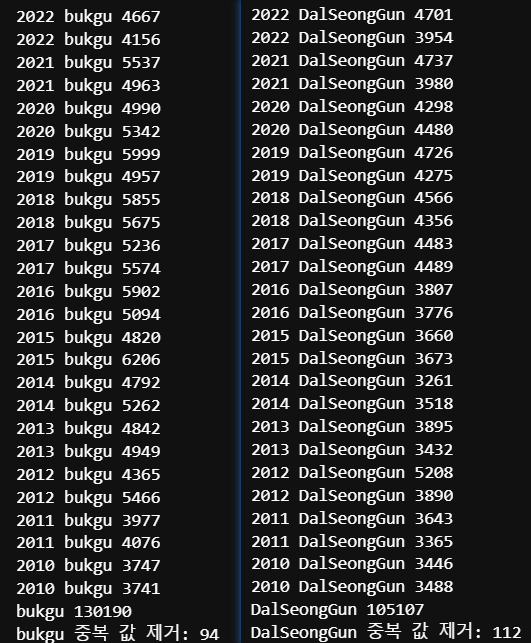
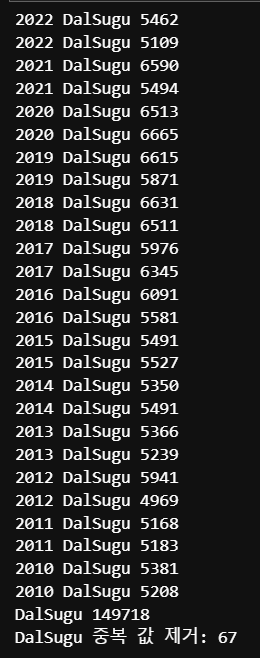
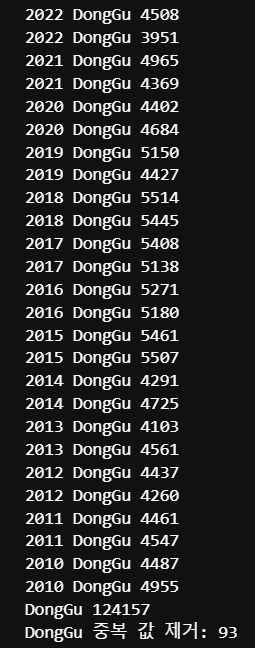
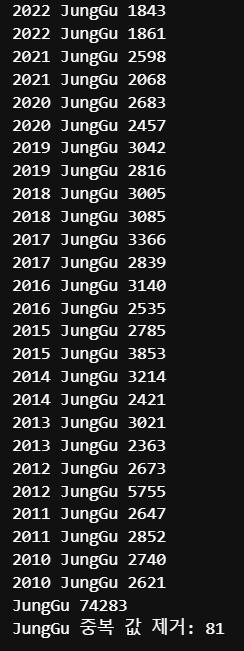
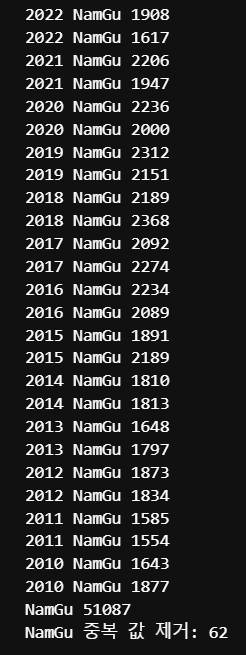
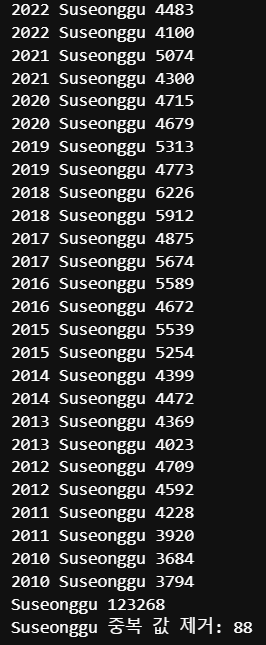

In [147]:
pd.read_csv('C:/Users/User/Desktop/경현/프로젝트/민원/Daegu_Complain_Classifficaion/전처리/경현/크롤링/complain_Bukgu_plus.csv')

,content,dept
0,건설기계사업자 변경신고,도시국 건설과
1,건설업상속신고,신성장전략국 일자리정책과
2,건설기계대여업등록,도시국 건설과
3,식품영업허가,보건소 위생과
4,유원시설업 (조건부영업)허가,신성장전략국 관광과
5,전화권유판매업변경신고,신성장전략국 일자리정책과
6,폐수배출시설 설치허가신청(설치신고),복지환경국 환경관리과
7,폐기물처리업(폐기물처리 신고자) 휴업·폐업·재개업 신고,복지환경국 자원순환과
8,배출부과금 징수유예 및 분납신청,복지환경국 환경관리과
9,"가축분뇨관련영업 [허가신청서, 변경허가신청서, 변경신고서]",복지환경국 환경관리과
